In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import scipy.stats as st
import arviz as az

D:\dev\playground\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Specify priors

In [2]:
mu = 0.0
sigma = 500.0
alpha = 1
beta = 0.2

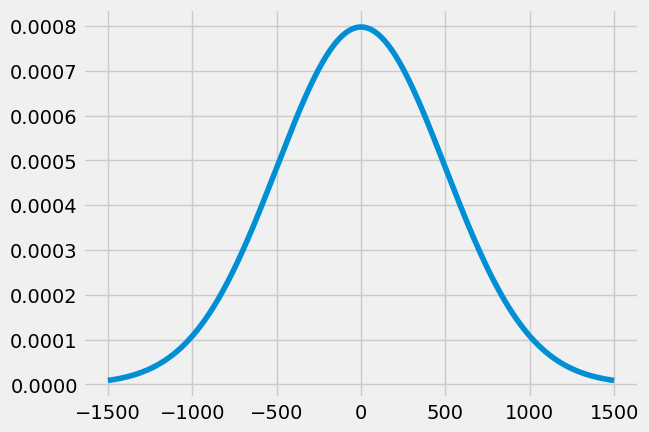

In [3]:
fig, ax = plt.subplots()
xs = np.linspace(-1500, 1500, 1000)
ys = st.norm(mu, sigma).pdf(xs)
ax.plot(xs, ys);

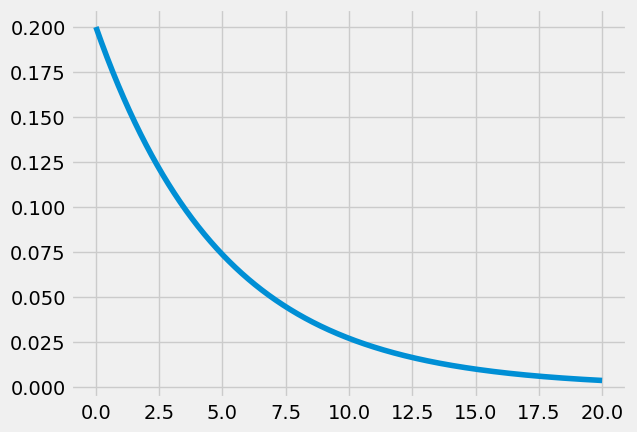

In [4]:
fig, ax = plt.subplots()
xs = np.linspace(0, 20, 1000)
ys = st.gamma(alpha, 0, 1/beta).pdf(xs)
ax.plot(xs, ys);

## Define the model - normal with unknown mean and variance

In [5]:
def model(obs=None):
    τ_α = numpyro.sample("τ_α", dist.Gamma(alpha, beta))
    μ_α = numpyro.sample("μ_α", dist.Normal(mu, τ_α**-1))
    numpyro.sample("obs", dist.Normal(μ_α, τ_α**-1), obs=obs)

## Simulate the data

In [6]:
n = 20
observed = st.norm(2, 4).rvs(n)

In [7]:
print(observed.mean())
print(observed.std())

0.7896217054013459
4.241774982808871


## Run MCMC - update the prior distributions to posteriors

In [8]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, obs=observed)

posterior_samples = mcmc.get_samples()

sample: 100%|█| 4000/4000 [00:06<00:00, 608.74it/s, 3 steps of size 7.81e-01. a


## Visualise the posteriors

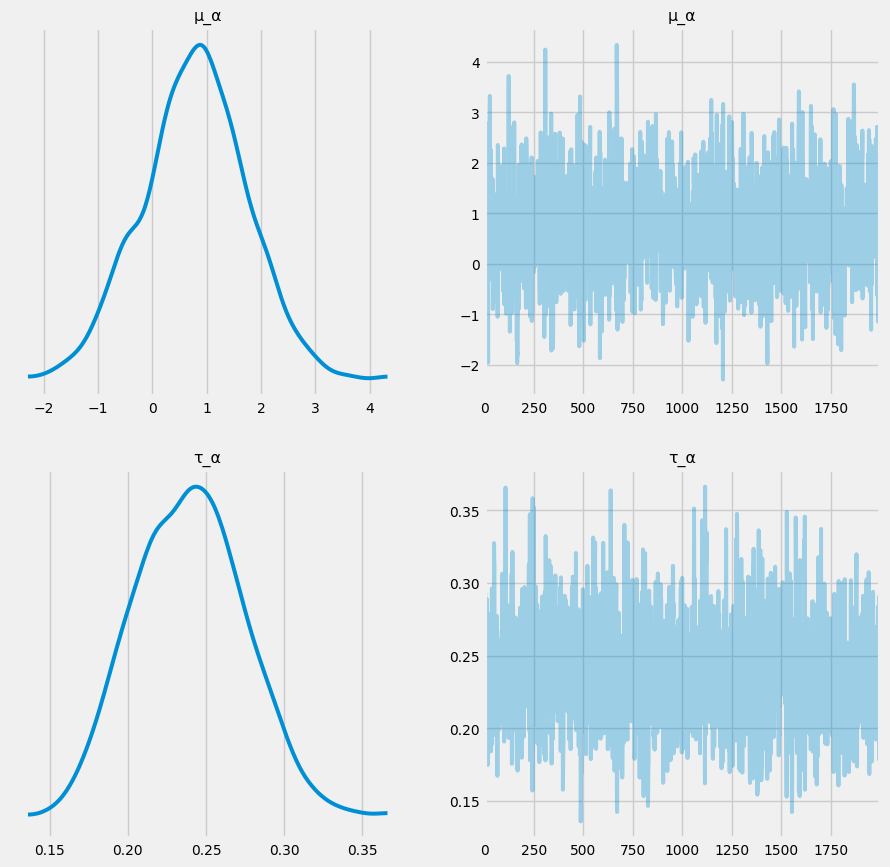

In [9]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(10, 10));

## Sample from the model - posterior predictive

In [10]:
predictive = Predictive(model, posterior_samples, return_sites=["obs", "μ_α"])
samples_predictive = predictive(random.PRNGKey(0), None)

### Posterior predictive for the mean
We compare with the theoretical distribution derived in the slides

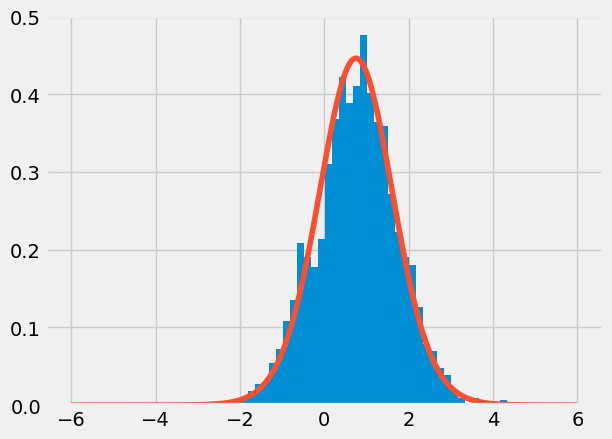

In [11]:
fig, ax = plt.subplots()
xs = np.linspace(-6, 6, 1000)
df = 2 * alpha + n
loc = 1 / (1 + n) * mu + n / (1+n) * observed.mean()
scale = (beta + (n-1) * observed.var(ddof=1) + n / (1 + n) * (mu-observed.mean())**2) / ((2 * alpha + n) * (n + 1))
ys = st.t(df=df, loc=loc, scale=np.sqrt(scale)).pdf(xs)
ax.hist(samples_predictive["μ_α"], bins=40, density=True);
ax.plot(xs, ys);

### Predictive posterior for the values

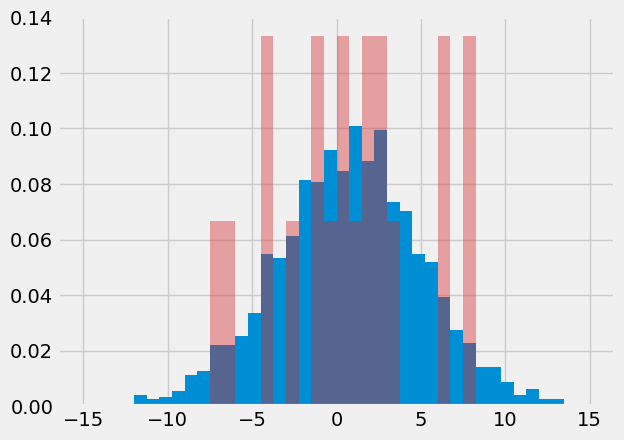

In [12]:
fig, ax = plt.subplots()
ax.hist(samples_predictive["obs"], bins=40, density=True, range=(-15,15));
ax.hist(observed, bins=40, density=True, color="tab:red", alpha=0.4, range=(-15,15));